# What is this notebook about?

Here we learn how to build images like this (see `sample_maps_times.png` if image below is not displayed) 

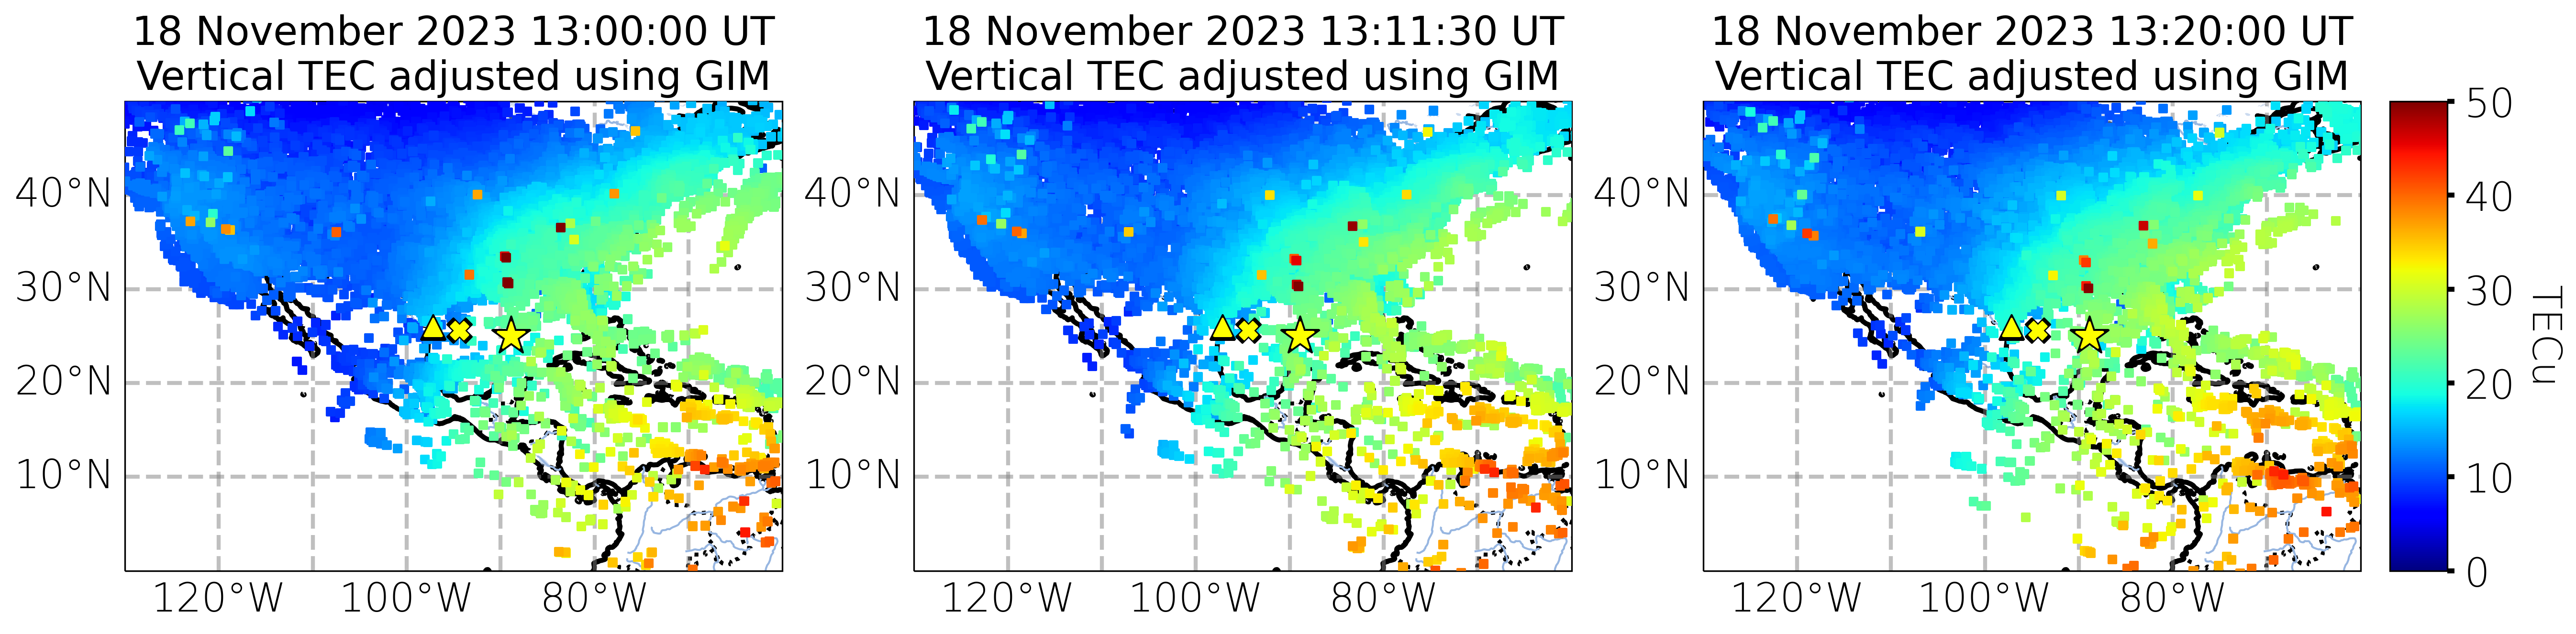

# Pre-requiriments

There are thing that you should perform in advance in order the notebook works.

* You should perform SIMuRG query for maps 
* Query is comleted and persist on the system, check it  `https://simurg.space/queries?email=simurg30s@simurg.iszf.irk.ru`
* You able to open link like this `https://simurg.space/ufiles/simurg30s@simurg.iszf.irk.ru/roti_2017_249_-90_90_N_-180_180_E_cbc4.h5` in browser

[Optional] and for your convinience you may use git and GitHub to obtain all notebooks of this series - notebooks are stored in repository `https://github.com/gnss-lab/studies`

# How to start using this notebook

Load anaconda to make sure we on the same page.

https://docs.conda.io/en/latest/

In anaconda propmt (or in linux bash):

```bash
conda deactivate
conda create -n simurg_cases python=3.10
conda activate simurg_cases
conda install jupyterlab
conda install cartopy
jupyter-lab
```

After jupyter lab is launched you will get execution enviroment for the notebook. To obtain all notebooks use git.

```bash
git clone https://github.com/gnss-lab/studies.git
cd ./studies
```

Or download them manually from `https://github.com/gnss-lab/studies`


# Install dependecies

Each notebook uses it set of python library. We keep them in separate cell to install from notebook itself. Jupyter kernel restart might be required. If you got `Module not found error`  anywhere in current notebook you can include this dependency below as separate line `!pip install module_that_was_not_found`

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install requests
!pip install h5py

# Load data from simurg 

Data appear for your queries (see it `https://simurg.space/queries?email=simurg30s@simurg.iszf.irk.ru`) and available via links like `https://simurg.space/ufiles/simurg30s@simurg.iszf.irk.ru/roti_2017_249_-90_90_N_-180_180_E_cbc4.h5` 

> **Note: You can check link is correct in advance by opening it in browser**

Lets define several structures to keep data in groups. We call separate kind of data as **data product**. So ROTI and TEC are different dataproducts. To deal with different data products you can extend members of `DataProducts` with that products. 

In [18]:
from dataclasses import dataclass
from enum import Enum

@dataclass
class ColorLimits():
    min: float
    max: float
    units: str

@dataclass
class DataProduct(): 
    long_name: str
    hdf_name: str
    color_limits: ColorLimits

@dataclass
class MapFile():
    url: str
    local_path: Path
    data_product: DataProduct

class DataProducts(Enum):
    roti = DataProduct("ROTI", "roti", ColorLimits(-0, 0.5, 'TECU/min'))

### Function for data download 

Futher develop function for data download. Variable `override` defines whther data should be downloaded in anyway or only when they not available locally. Function introduces progress bar via `response.iter_content()` and `sys.stdout.write()`, `sys.stdout.flush()`. The progress bar looks like:

```bash
Downloading roti.h5
[===============================                   ]
```

In [32]:
import requests
import os
import sys
from pathlib import Path
import logging

logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)

def load_data(
    url: str, 
    local_file: Path,
    override: bool = False
) -> None:
    if local_file.exists() and not override:
        print(f"File {local_file} exists. Use override=True to download it again.")
        return 
        
    with open(local_file, "wb") as f:
        print(f"Downloading {local_file}")
        response = requests.get(url, stream=True)
        total_length = response.headers.get('content-length')

        if total_length is None: 
            f.write(response.content)
        else:
            dl = 0
            previous = 0
            total_length = int(total_length)
            for chunk in response.iter_content(chunk_size=4096):
                dl += len(chunk)
                f.write(chunk)
                done = int(50 * dl / total_length)
                if done > previous: # to prevent warnings from notebook
                    sys.stdout.write("\r[%s%s]" % ('=' * done, ' ' * (50-done)) )    
                    sys.stdout.flush()
                previous = done
            sys.stdout.write("\n")

### Actual data download

Now we are ready to defime `MapFile` object and call `load_data()`.

> **To work with your data change link `https://simurg.space/ufiles/simurg30s@simurg.iszf.irk.ru/roti_2017_249_-90_90_N_-180_180_E_cbc4.h5` to proper one.**

In [34]:
map_files = {
    "roti": MapFile(
        "https://simurg.space/ufiles/simurg30s@simurg.iszf.irk.ru/roti_2017_249_-90_90_N_-180_180_E_cbc4.h5",
        Path("roti.h5"),
        DataProducts.roti
    ),
}
load_data(map_files["roti"].url, map_files["roti"].local_path, override=False)

[==================================================]


# SIMuRG map data structure/model

SIMuRG relies of HDF data format to store data. We use different structure for different kind of data. User queries for map data (see **Load data** section above) have quite simple dates structure:

```
HDF_FILE
    -> data
        -> timestamp1       (structured array)
            .. latitutdes   (column)
            .. longitudes   (column) 
            .. values       (column) 
        -> timestamp2
            .. latitutdes 
            .. longitudes
            .. values

        ....

       -> timestampN
            .. latitutdes 
            .. longitudes
            .. values
    -> metadata
```

When we open HDF file we see `data` and `metadata` dataHDF groups. Inside `data` there are HDF datasets named something like `2023-11-18 13:00:05.000000` (`timestampX` on scheme) that contain map for particular epoch. When make slice of data we obtain [structured numpy array](https://numpy.org/doc/stable/user/basics.rec.html) that we can index using `'lat'`, `'lon'`, `'vals'` to select particular column; or using number of the raws to select particular point

```python
data_file =  h5py.File(file_name, 'r')
str_times = data_file['data'].keys() # -> [2023-11-18 13:00:00.000000, 2023-11-18 13:00:05.000000 ... ]
map_data_array = data_file['data']['2023-11-18 13:00:05.000000'][:]
lats = map_data_array['lat'] # -> array([53.98024278, ..., 31.67502274, 27.34885691])
data = map_data_array['vals']
point = map_data_array[100] # -> (44.19579786, -121.70615637, 0.03613366)
```

### Function for data reading below

You can retrieve all maps or just those that belong to particular `times`.  

In [72]:
from datetime import datetime
from numpy.typing import NDArray
from dateutil import tz
import logging
import h5py

_UTC = tz.gettz('UTC')
SIMURG_MAP_TIME_KEY_FORMAT = '%Y-%m-%d %H:%M:%S.%f'

def retrieve_data(
    file: str | Path,
    epochs: list[datetime] = []
) -> dict[datetime, NDArray]:    
    """
    Retrieves data from HDF file and put in dictionary
    Keys are datetime.datetime values are structured numpy arrays
    file - path to file
    times - times to preserve in output
    """  
    f_in = h5py.File(file, 'r')
    lats = []
    lons = []
    values = []
    data = {}
    file_epochs = []
    for str_time in list(f_in['data'])[:]:
        epoch = datetime.strptime(str_time, SIMURG_MAP_TIME_KEY_FORMAT)
        epoch = epoch.replace(tzinfo=epoch.tzinfo or _UTC)
        file_epochs.append(epoch)
        if epochs and not epoch in epochs:
            continue
        file_epochs.append(epoch)
        data[epoch] = f_in['data'][str_time][:]
    missed_epochs = [epoch for epoch in epochs if not epoch in file_epochs]
    if missed_epochs:
        logging.warning(f"Requested {missed_epochs} could not be found in file {file}")
    return data

### Actual data reading

We can get all maps or only some of them. In case if requested epoch not in file (due to type for example) we get warning.

In [75]:
# read all maps in file
maps = retrieve_data(map_files["roti"].local_path)

In [76]:
# read only maps for given epoch
times = [
    datetime(2017, 9, 6, 11, 38).replace(tzinfo=_UTC)
]
maps = retrieve_data(map_files["roti"].local_path, epochs=times)

In [77]:
# typo in datetime cause warning
times = [
    datetime(2017, 9, 6, 11, 30).replace(tzinfo=_UTC)
]
maps = retrieve_data(map_files["roti"].local_path, epochs=times)

# Data plotting

### Layout 

Each plot consist of layout and data. Data are maps retrieved from SIMuRG and layout define how. Parameters such font size for different objects (title, axis labels etc) defined as `DEFAULT_PARAMS` and updated for plots via `rcParams.update()`. 

> **Make sure that using proper parameter names so the matplotlib undertands it. See [rcparams](https://matplotlib.org/stable/users/explain/customizing.html)**

We use `cartopy` to handle geo object and projection. For example features like `COASTLINE` applicable only when cartopy is used bu not with pure matplotlib. The cartopy usage comes by projection see `subplot_kw={'projection': ccrs.PlateCarree()}` in plot_map().

```python
ax.add_feature(geofeature.COASTLINE, linewidth=2.5)
ax.add_feature(geofeature.BORDERS, linestyle=':', linewidth=2)
ax.add_feature(geofeature.LAKES, alpha=0.5)
ax.add_feature(geofeature.RIVERS)
```

If you need additional features like solar terminator or magnetic equator they also should be placed in `prepare_layout()`

In [141]:
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from cartopy import feature as geofeature

DEFAULT_PARAMS = {
    'font.size': 20,
    'figure.dpi': 300,
    'font.family': 'serif',
    #'font.family': 'monospace',
    'font.style': 'normal',
    'font.weight': 'light',
    'legend.frameon': True,
    'font.variant' : 'small-caps',
    'axes.titlesize' : 20,
    'axes.labelsize' : 20,
    'xtick.labelsize' : 18,                         
    'xtick.major.pad': 5,
    'ytick.major.pad': 5,   
    'xtick.major.width' : 2.5,
    'ytick.major.width' : 2.5,
    'xtick.minor.width' : 2.5,
    'ytick.minor.width' : 2.5,
    'ytick.labelsize' : 20,
}

def prepare_layout(
    ax: plt.axes, 
    lon_limits: tuple[float],
    lat_limits: tuple[float],
    lon_locator: list[float],
    lat_locator: list[float]               
) -> None:
    """Takes matplotlib.pyplot.axes makes puts landmarks and formatting
    
    lon_limits - define horizontal axes span
    lat_limits - define vertical axes span
    lon_locator, lat_locator - define which axis labels are visible
    """
    plt.rcParams.update(DEFAULT_PARAMS)
    gl = ax.gridlines(
        linewidth=2, 
        color='gray', 
        alpha=0.5, 
        draw_labels=True, 
        linestyle='--'
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    if lon_locator:
        gl.xlocator = mticker.FixedLocator(lon_locator)
    ax.set_xlim(*lon_limits)
    ax.set_ylim(*lat_limits)
    #put some features on the map
    ax.add_feature(geofeature.COASTLINE, linewidth=2.5)
    ax.add_feature(geofeature.BORDERS, linestyle=':', linewidth=2)
    ax.add_feature(geofeature.LAKES, alpha=0.5)
    ax.add_feature(geofeature.RIVERS)

### Function for data plotting

The function is big, however it covers many features that should be presented on figure that we submit to the publication.

In [142]:
import cartopy.crs as ccrs
import numpy as np

TIME_FORMAT_TITLE = '%d %B %Y %H:%M:%S.%f'

@dataclass
class MapPlotParams():
    point_size: int
    point_marker: str
    cmap: str

def plot_map(
    *,
    data: dict[DataProduct, dict[datetime, NDArray]], 
    plot_times: list[datetime], 
    products: DataProduct | list[DataProduct],
    nrows: int, 
    ncols: int,
    labels: dict[str, tuple[float]] = {},
    lon_limits: tuple[float] = (-180, 180), 
    lat_limits: tuple[float] = (-90, 90),
    lon_locator: list[float] = [],
    lat_locator: list[float] = [],
    sort: bool = False,
    use_alpha: bool = False,
    savefig: str | Path = '',
    map_params: MapPlotParams = MapPlotParams(15, 's', 'jet'),
    title: str | None = None,
    time_mark_location: tuple | None = None,
    subplot_marks: list | None = None,
    subplot_width: float = 5.7,
    subplot_height: float = 5.7,
) -> None:
    """
    Plotting data on globe (or part of globe)
    """  
    if isinstance(products, list):
        assert len(products) == nrows
        assert len(plot_times) == ncols
    else:
        assert len(plot_times) == ncols * nrows
        products = [products] * (len(plot_times) // ncols)
    fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                            subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(subplot_width*ncols + 3, subplot_height * nrows), 
                            dpi=DEFAULT_PARAMS["figure.dpi"])
    if subplot_marks:
        assert len(subplot_marks) == ncols * nrows
    if nrows * ncols > 1:
        axs=axs.flatten()
    else:
        axs=[axs]
        
    for itime in range(ncols):
        for iprod in range(nrows):
            
            axs_index = itime + ncols * iprod
            ax1 = axs[axs_index]
            if ncols * nrows == len(plot_times):
                time = plot_times[axs_index]
            else:
                time = plot_times[itime]
            prod = products[iprod]
            if time not in data[prod]:
                print(f"{time} is not presented among {data[prod].keys()}")
                
            if sort:
                arr = np.sort(data[prod][time], order='vals')
            else:
                arr = data[prod][time]
            lats = arr['lat'] 
            lons = arr['lon'] 
            values = arr['vals']

            prepare_layout(ax1, lon_limits, lat_limits, lon_locator, lat_locator)
            
            # alpha use to create transparent plot of data
            if use_alpha:
                m = max(np.max(values), -np.min(values))
                alphas = [(v+m/4)/(m+m/4) for v in values]
                alphas = [abs(a) for a in alphas]
            else:
                alphas = [1 for _ in values]

            #data plot
            color_limits = prod.value.color_limits
            sctr = ax1.scatter(
                lons, lats, c=values,
                alpha = alphas,
                marker = map_params.point_marker, 
                s = map_params.point_size, 
                zorder = 3,  
                vmin = color_limits.min,
                vmax = color_limits.max, 
                cmap = map_params.cmap
            )
            for label, (lon, lat) in labels.items():
                plt.text(
                    lon, lat, label,
                    horizontalalignment='right',
                    transform=ccrs.Geodetic(),
                    size=DEFAULT_PARAMS['font.size'] / 2,
                    color="white",
                    path_effects=[pe.withStroke(linewidth=1, foreground="black")]
                )
                       
            if title is None:
                _title = '\n' + prod.value.long_name.replace('-', '–') 
            elif title == "":
                _title = None
            else:
                _title = '\n' + title
            if not _title is None:
                if iprod == 0:
                    ax1.set_title(time.strftime(TIME_FORMAT_TITLE)[:-7]+' UT'+ _title)
                else:
                    ax1.set_title(_title)
            if itime % ncols == ncols - 1:
                cax = fig.add_axes([ax1.get_position().x1+0.01,
                                    ax1.get_position().y0,
                                    0.02,
                                    ax1.get_position().height])
                cbar = ax1.figure.colorbar(sctr, cax=cax)
                if prod.value.long_name == "ROTI":
                    cbar_label =  color_limits.units + "\n" 
                else:
                    cbar_label = color_limits.units
                cbar.ax.set_ylabel(cbar_label, rotation=-90, va="bottom")
            if not time_mark_location is None:
                ax1.text(
                    *time_mark_location, 
                    time.strftime("%H:%M UT"),
                    #f"{time.hour}:{time.minute} UT",
                    size=DEFAULT_PARAMS['font.size'] * 1.25,
                    weight='bold'
                )
            if subplot_marks:
                ax1.text(
                    lon_limits[0], lat_limits[1]-4,
                    subplot_marks[axs_index],
                    size=DEFAULT_PARAMS['font.size'] * 1.25,
                    weight='bold',
                )

   
            directory = os.getcwd()
    plt.subplots_adjust(left=0.0, wspace=0.05)
    if savefig:
        #plt.tight_layout()    
        plt.savefig(savefig)
    else:
        plt.show()
    plt.close()

    plt.rcdefaults()

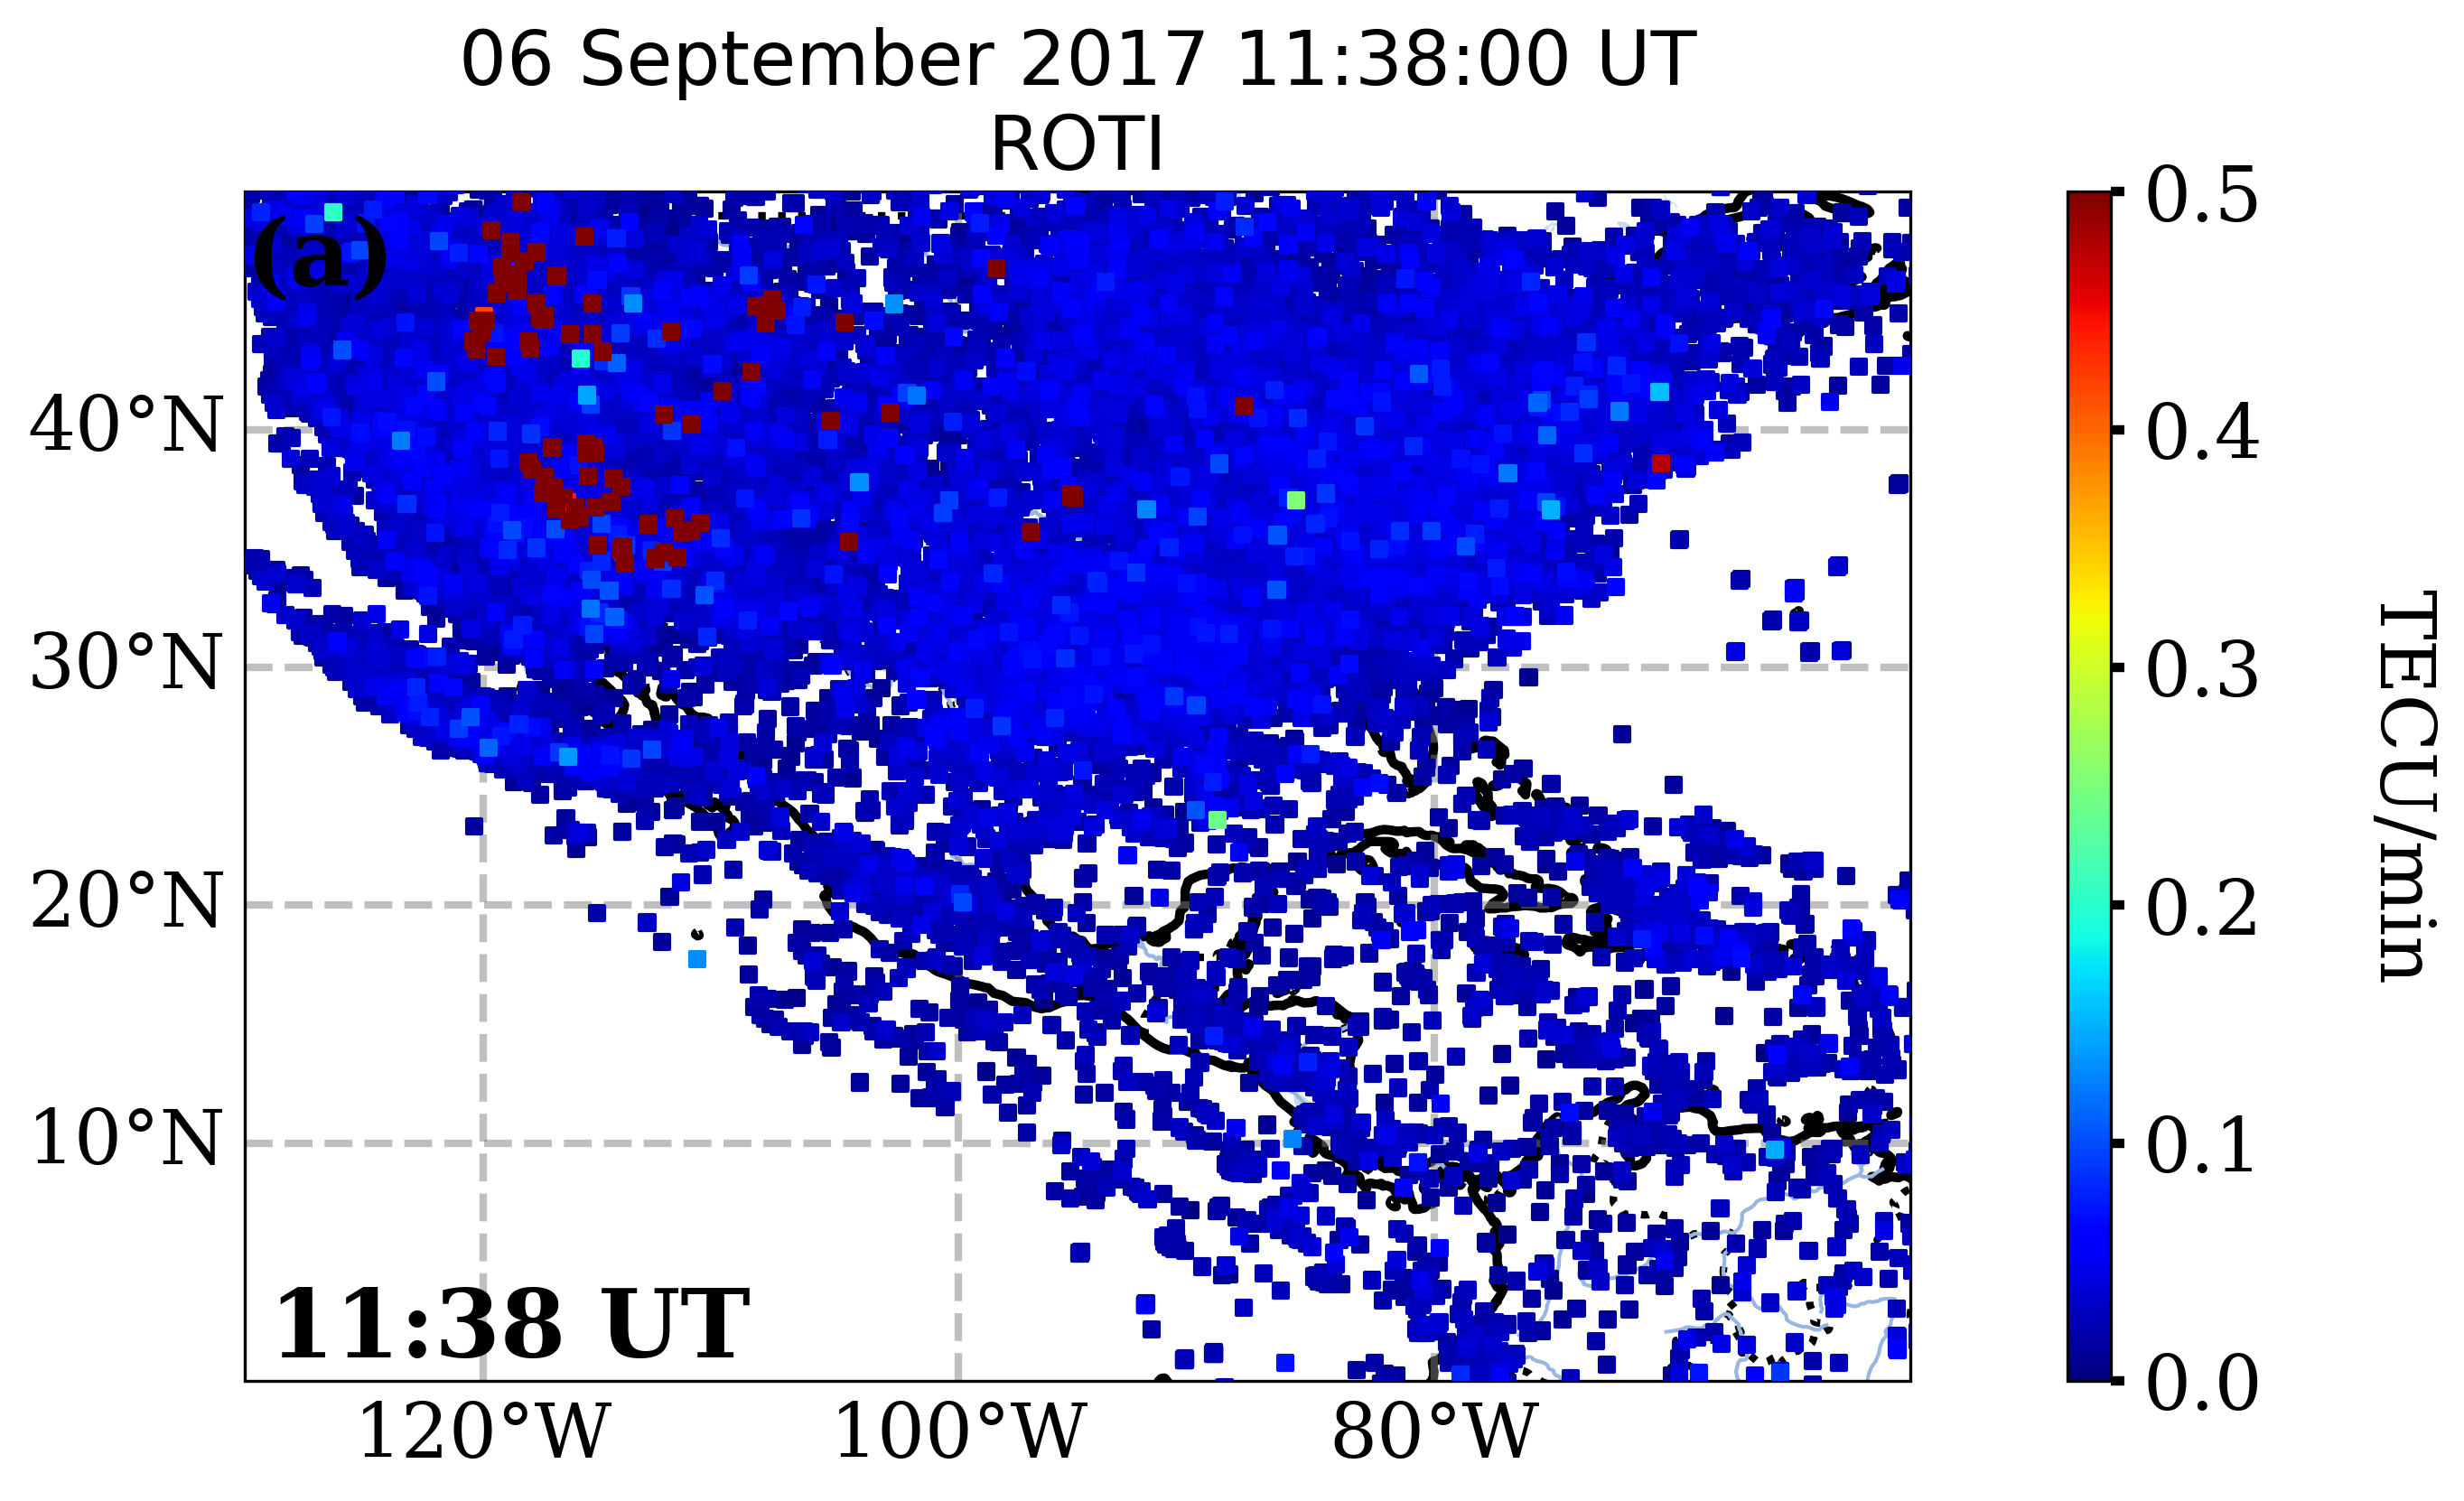

In [143]:
times = [
    datetime(2017, 9, 6, 11, 38).replace(tzinfo=_UTC)
]
maps_data = retrieve_data(map_files["roti"].local_path, epochs=times)
plot_map(
    data={DataProducts.roti: maps_data}, 
    plot_times=times,
    products=DataProducts.roti,
    nrows=1,
    ncols=1,
    lon_limits = (-130, -60),
    lat_limits = (0, 50),
    sort=True,
    savefig="",
    lon_locator = [-120, -100, -80],
    time_mark_location=(-129, 1),
    subplot_marks=["(a)"],
    subplot_width=5
)

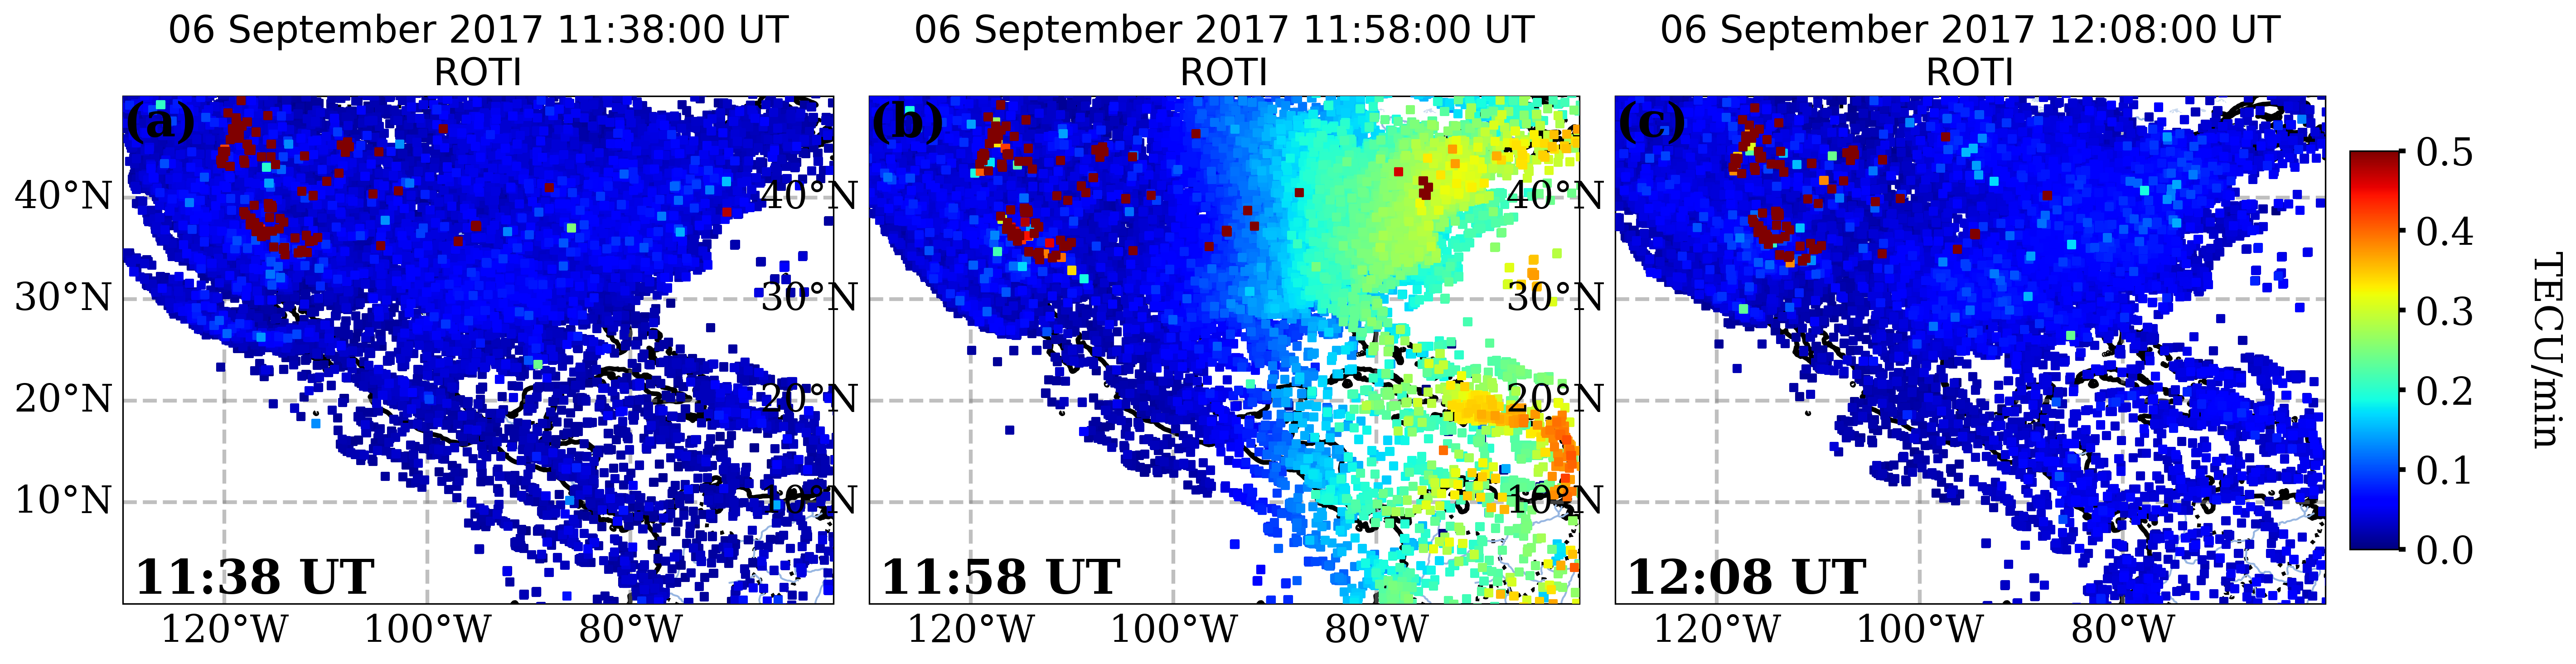

In [147]:
times = [
    datetime(2017, 9, 6, 11, 38).replace(tzinfo=_UTC),
    datetime(2017, 9, 6, 11, 58).replace(tzinfo=_UTC),
    datetime(2017, 9, 6, 12, 8).replace(tzinfo=_UTC)
]
maps_data = retrieve_data(map_files["roti"].local_path, epochs=times)
plot_map(
    data={DataProducts.roti: maps_data}, 
    plot_times=times,
    products=DataProducts.roti,
    nrows=1,
    ncols=3,
    lon_limits = (-130, -60),
    lat_limits = (0, 50),
    sort=True,
    savefig="",
    lon_locator = [-120, -100, -80],
    time_mark_location=(-129, 1),
    subplot_marks=["(a)", "(b)", "(c)"],
    subplot_width=5
)